# Medical Cost Prediction
## Importing libraries needed
- numpy
- pandas
- matpotlib.pyplot
- math

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

## Changing data set to be suitable for our project

In [2]:
# loading data
data = pd.read_csv('insurance.csv')

print("Table data")
display(data.head())

Table data


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### We have to change string data into numerical values
#### This data set contains the following columns
+ age : integer
+ sex: (female, male)
+ bmi : floating point
+ children : integer
+ smoker : (yes, no)
+ region : (northeast, southeast, southwest, northwest)
+ charges : floating point

#### We are mapping values as follows
+ male -> 1
+ female -> 0
+ yes -> 1
+ no -> 0
+ (northeast, southeast, southwest, northwest) -> (1, 2, 3, 4)

In [3]:
data["sex"] = data["sex"].map({"male" : 1, "female":0})
data["smoker"] = data["smoker"].map({"yes":1, "no":0})
data["region"] = data["region"].map({"northeast": 1, "southeast":2, "southwest":3, "northwest":4})

display(data.head())

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,4,21984.47061
4,32,1,28.880,0,0,4,3866.85520


#### Vectorizing

In [4]:
features = ["age", "sex", "bmi", "children", "smoker", "region"]
x_train = data[features].to_numpy()
y_train = data["charges"].to_numpy()

print(f"x_train:\n {x_train}\n")
print(f"x_order: {np.shape(x_train)}")
print(f"y_train:\n {y_train}\n")
print(f"y_order: {np.shape(y_train)}")

x_train:
 [[19.    0.   27.9   0.    1.    3.  ]
 [18.    1.   33.77  1.    0.    2.  ]
 [28.    1.   33.    3.    0.    2.  ]
 ...
 [18.    0.   36.85  0.    0.    2.  ]
 [21.    0.   25.8   0.    0.    3.  ]
 [61.    0.   29.07  0.    1.    4.  ]]

x_order: (1338, 6)
y_train:
 [16884.924   1725.5523  4449.462  ...  1629.8335  2007.945  29141.3603]

y_order: (1338,)


Now x_train is a matrix containing our training feature data. Each column is a feature and each row is an example.
An element in the matrix can be represented as x<sub>f</sub><sup>e</sup> such that,
    f = 1,2,...,6 e = 1,2,...,1338 where f is the feature and e is the example.

### Z score normalization

$$x_{scaled} = \frac{x - \mu}{\sigma}$$

Since some feature values are too large compared to others we have to rescale them to fall between -1 and 1. For that we use z score normalization.
We get the difference between the feature value and the mean (${\mu}$) and divide it by the standard diviation (${\sigma}$).

In [5]:
#getting the mean
x_mean = np.mean(x_train, axis=0, keepdims=True)
print(x_mean)

[[39.20702541  0.50523169 30.66339686  1.09491779  0.20478326  2.48654709]]


In [6]:
#getting standard diviation
x_sigma = np.std(x_train, axis=0, mean=x_mean)
print(x_sigma)

[14.04470904  0.49997263  6.09590764  1.20504217  0.40354315  1.10450154]


In [7]:
#calculating z score and normalise values
x_scaled = (x_train-x_mean)/x_sigma
print(x_scaled)

[[-1.43876426 -1.0105187  -0.45332    -0.90861367  1.97058663  0.46487297]
 [-1.50996545  0.98959079  0.5096211  -0.07876719 -0.5074631  -0.44051282]
 [-0.79795355  0.98959079  0.38330685  1.58092576 -0.5074631  -0.44051282]
 ...
 [-1.50996545 -1.0105187   1.0148781  -0.90861367 -0.5074631  -0.44051282]
 [-1.29636188 -1.0105187  -0.79781341 -0.90861367 -0.5074631   0.46487297]
 [ 1.55168573 -1.0105187  -0.26138796 -0.90861367  1.97058663  1.37025876]]


## Linear Regression function
we use the following function to get the target value
$$ f_{\mathbf{w},b}(\mathbf{x}) = w_0x_0 + w_1x_1 + ... +w_{n-1}x_{n-1} + b $$
or in vector form
$$ f_{\mathbf{w},b}(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x} + b $$

Here, $\mathbf{w}$ is the weights vector and $\mathbf{x}$ is x_scaled.  
b is a scalar.

In [8]:
# initializing weights and b
n_features = np.shape(x_scaled)[1]
w_init = np.zeros(n_features)
b_init = 0
print(w_init, b_init)

[0. 0. 0. 0. 0. 0.] 0


In [9]:
# creating the linear regression function
def predict(w:np.ndarray, b:float, X:np.ndarray):
    """
    Computes the prediction of a multiple linear regression model.
    
    Args:
    X (ndarray): Shape (m, n). The scaled feature matrix.
    w (ndarray): Shape (n,). The weights assigned to each feature.
    b (scalar): The bias or intercept term.
    
    Returns:
    p (ndarray): Shape (m,). A 1D array of predicted values.
    """
    p = np.dot(X, w) + b
    return p

## Cost Function
$$J(\mathbf{w},b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})^2 $$ 
where:
$$ f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x}^{(i)} + b $$ 

m is the number of examples and i is the variable to go through all the examples

In [10]:
def cost_fun(w, b, X, y):
    """
    compute cost
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      cost (scalar): cost
    """
    m = np.shape(X)[0]
    error = predict(w, b, X) - y #gives a vector of R m of error values
    cost = np.linalg.norm(error)**2 / (2*m) #calculating the norm of the error vector and squaring it gives the sum of square errors

    return cost
cost_fun(w_init, b_init, x_scaled, y_train)

np.float64(161323436.79435232)

## Gradient descent for multiple variables:

$$\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline\;
& w_j = w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j}   \; & \text{for j = 0..n-1}\newline
&b\ \ = b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b}  \newline \rbrace
\end{align*}$$

where, n is the number of features, parameters $w_j$,  $b$, are updated simultaneously and where  

$$
\begin{align}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)}   \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) 
\end{align}
$$
* m is the number of training examples in the data set

    
*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is the model's prediction, while $y^{(i)}$ is the target value


In [11]:
def gradient_w_b(w,X,b,y):
    """
    compute gradient
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      grdient_w (vector): shape (n,). A 1D array of gradients of cost function by weights(w) for all n features
      gradient_b (scalar) : the gradient of cost function by b
    """
    p = predict(w,b,X)
    error_vector = p - y
    m = np.shape(X)[0]
    m_ones = np.ones(m, dtype=int)
    gradient_w = np.dot(error_vector, X)/m 
    gradient_b = np.dot(m_ones, error_vector)/m
    return gradient_w, gradient_b

In [12]:
def get_gradient_decent(alpha, w_init, b_init, X, y):
    convergent = False
    iterations = 0
    max_iterations = 10000
    w = w_init.copy() #keeping the oroginal w_init safe
    b = b_init
    J_history = [cost_fun(w, b, x_scaled, y_train)] #cost (J) before any iteration
    while(not convergent and iterations<max_iterations):
        w_prev = w.copy()
        b_prev = b
        w_gradient, b_gradient = gradient_w_b(w, x_scaled, b, y_train)
        w = w - alpha*w_gradient
        b = b - alpha*b_gradient
        J = cost_fun(w, b, x_scaled, y_train)
        J_history.append(cost_fun(w, b, x_scaled, y_train)) #adding cost after an iteration for plotting
        iterations += 1
        if(np.allclose(w_prev, w) and math.isclose(b_prev, b)):
            convergent = True
            #now we must have found w and b valuse for the minimum cost
            print(f"converged after {iterations} iterations")
    if (not convergent):
        print("Iterations reached the maximum amount")
    return w, b, J_history

w, b, J_history = get_gradient_decent(alpha=0.01, w_init=w_init, b_init=b_init, X=x_scaled, y=y_train)


converged after 1605 iterations


#### We have obtained the ideal values as w and b

## Plotting the Cost against iterations

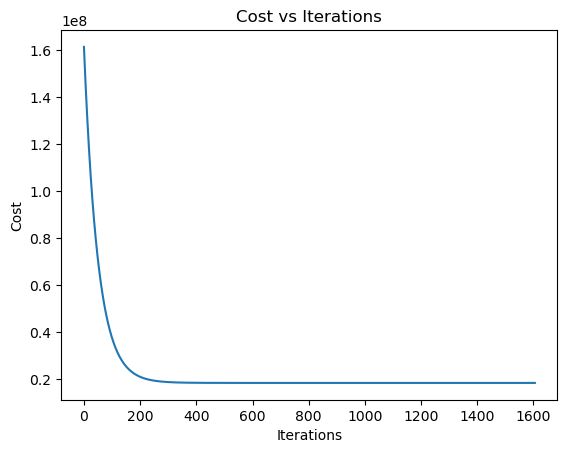

In [13]:
fig, ax = plt.subplots()
ax.plot([i for i in range(len(J_history))], J_history)
ax.set_title("Cost vs Iterations")
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.show()

This graph shows that our gradient decent algorithm is working properly.

## Testing the model performance
Now we draw a plot of predicted values (y_hat) against training values (y_train).  
We are now assigning the ideal w and b to the predict function and get the array of predicted values.

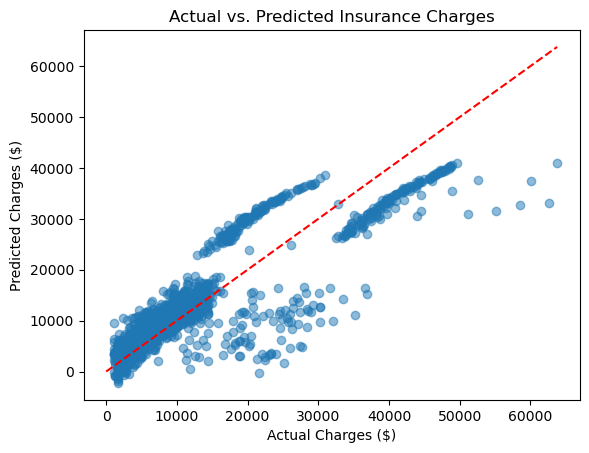

In [14]:
predictions = predict(w, b, x_scaled)
y_actual = y_train.copy()
plt.scatter(y_actual, predictions, alpha=0.5)
plt.xlabel("Actual Charges ($)")
plt.ylabel("Predicted Charges ($)")
plt.title("Actual vs. Predicted Insurance Charges")

# Draw a diagonal line representing perfect predictions
max_val = max(np.max(y_actual), np.max(predictions))
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--')

plt.show()